## Visualize Metrics: Spectrograms & Historgrams

In [537]:
import scipy
import scipy.signal
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append("../")
sys.path.append("../visualize")
sys.path.append("../data/")
sys.path.append("../artifacts/")
from load_EEGs_mc import EEGDatasetMc
import stacklineplot
from constants import *
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [12, 7]

### Load Data

In [531]:
filename = "../results/sample_800.npy"
sample_generated = np.load(filename)

In [532]:
files_csv = "../data/dataset_csv/sample_file.csv"
dataset = EEGDatasetMc(files_csv, select_channels=list(range(4)), max_num_examples=1000, length=784)

In [533]:
sample_real = dataset[5]
sample_real = sample_real.numpy()

In [535]:
def get_samples_real_stack(dataset, n=-1):
    # reutns all examples of dataset in a singe batch
    if n == -1:
        n = len(dataset)
    out = np.zeros(dataset[0].shape)
    for i in range(n):
        out = np.vstack((out, dataset[i].numpy()))
    return out
    

In [213]:
sample_real = get_samples_real_stack(dataset)

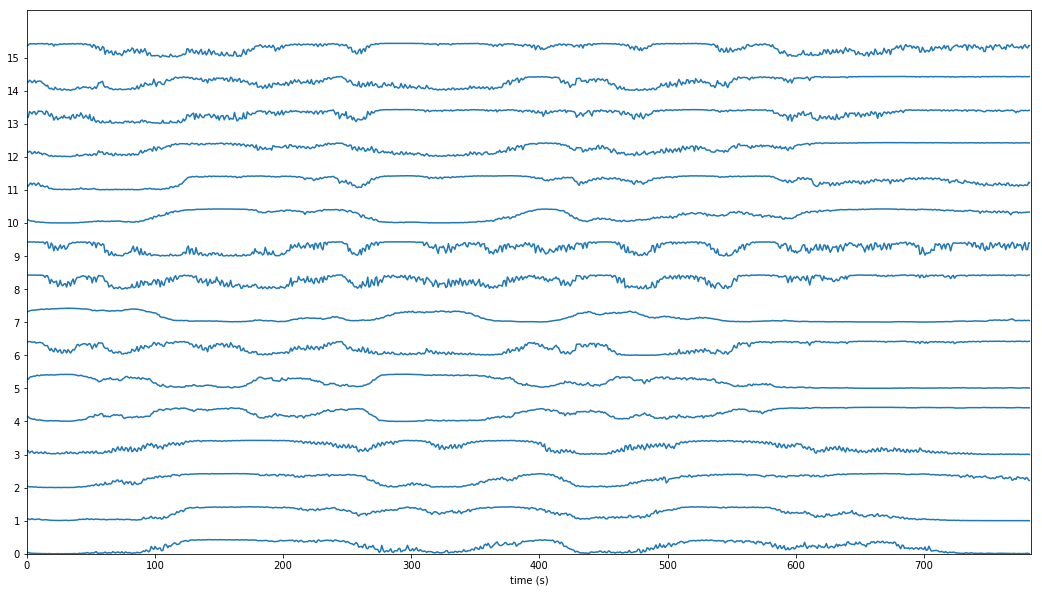

In [171]:
stacklineplot.stackplot(sample_real, yscale=.3)

### Spectrograms

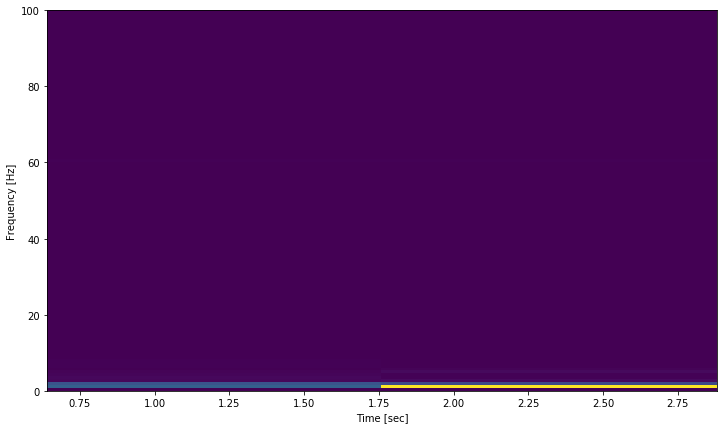

In [538]:
# Spectrogram of a Single Generated Recording
f, t, Sxx = scipy.signal.spectrogram(sample_generated[1], 200)
Sxx = Sxx / np.linalg.norm(Sxx)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [539]:
def compute_spectrogram(signals, fs=200, graph=False):
    window = ('tukey', .25) # turkey is the default
#     window = scipy.signal.triang(60)
    f, t, Sxx = scipy.signal.spectrogram(signals, fs, window=window)
    Sxx = Sxx / np.linalg.norm(Sxx)
    if graph:
        plt.pcolormesh(t, f, Sxx)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
    
    return  f, t, np.squeeze(Sxx)

In [540]:
def compute_average_spectrogram(signals, fs=200, graph=False):
    
    f, t, total_spectrogram = compute_spectrogram(signals)
    total_spectrogram = np.sum(total_spectrogram, axis=0)
    
    if graph:
        plt.pcolormesh(t, f, total_spectrogram)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
    
    total_spectrogram = np.sum(total_spectrogram, axis=1)
    total_spectrogram /= signals.shape[0]
    
    return total_spectrogram
        

Real Samples AVG

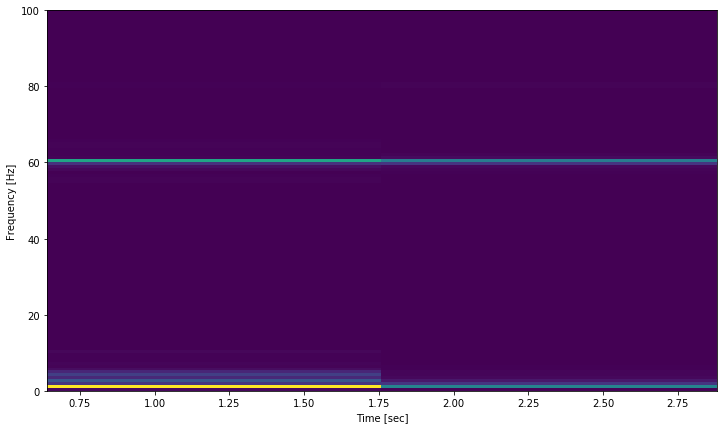

(129,)

In [541]:
compute_average_spectrogram(sample_real, graph=True).shape

Generated Samples AVG

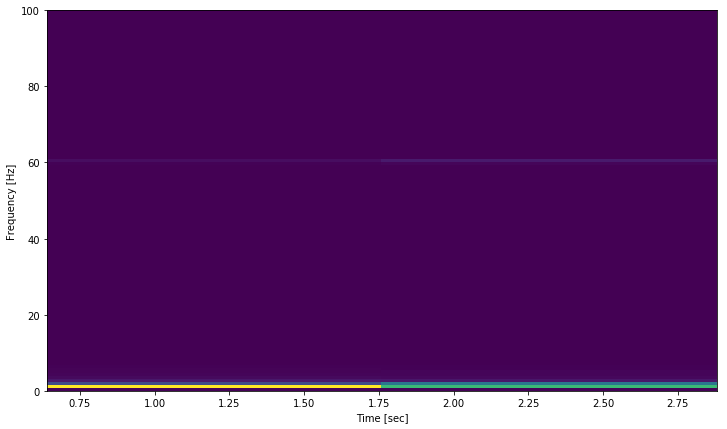

(129,)

In [542]:
compute_average_spectrogram(sample_generated, graph=True).shape

In [543]:
def get_signal_diff_spectrogram(signals_a, signals_b):
    m_singals_a = signals_a.shape[0]
    m_singals_b = signals_b.shape[0]
    assert(signals_a.shape[1] == signals_b.shape[1]), "signals should be equal length"
    combined = np.vstack((signals_a, signals_b))
    _, _, combined_spectrogram = compute_spectrogram(combined)
    
    combined_spectrogram = np.sum(combined_spectrogram, axis=2)
    
    spectrogram_a = combined_spectrogram[:m_singals_a]
    spectrogram_b = combined_spectrogram[m_singals_a:]
    
    # Reduce dimension again b/c time dim isn't relevant - just want total amount of freq
    spectrogram_a = np.sum(spectrogram_a, axis=0)
    spectrogram_b = np.sum(spectrogram_b, axis=0)
    
    return np.sum(np.abs(spectrogram_a - spectrogram_b)) / (m_singals_a + m_singals_b) * .4e3

In [544]:
print("Should be near 0:", get_signal_diff_spectrogram(sample_real[:2000], sample_real[2000:]))
print("Should be higher:", get_signal_diff(sample_real, sample_generated))

Should be near 0: 659.6066474914551
Should be higher: 0.23937618732452393


### Historgrams

Generated EEGs

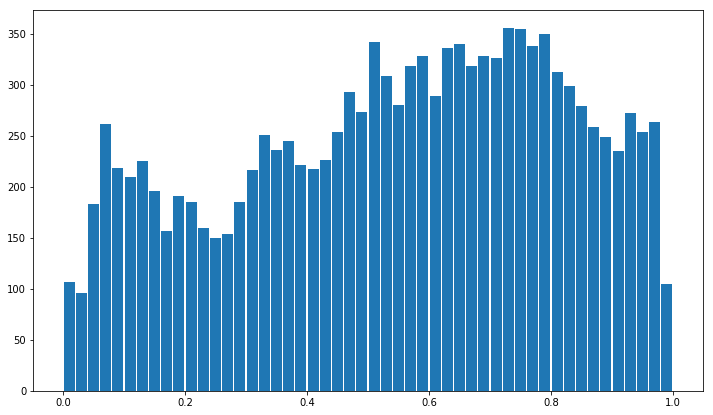

In [549]:
sample = sample_generated
sample_flattened = sample.reshape(-1)
hist, bins = np.histogram(sample_flattened, range=(0,1), bins=50)
width = .9 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

Real EEGs

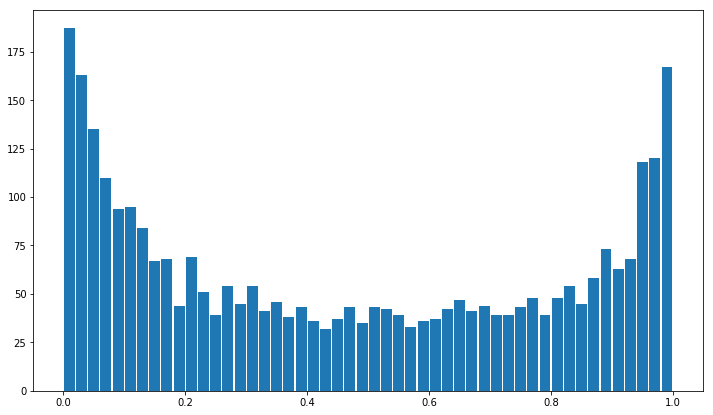

In [550]:
sample = sample_real
sample_flattened = sample.reshape(-1)
hist, bins = np.histogram(sample_flattened, range=(0,1), bins=50)
width = .9 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()


In [547]:
def get_signal_diff_histogram(signals_a, signals_b, n_bins=50):
    signals_a = signals_a.reshape(-1)
    signals_b = signals_b.reshape(-1)
    hist_a, _ = np.histogram(signals_a, bins=n_bins)
    hist_b, _ = np.histogram(signals_b, bins=n_bins)
    return np.sum(np.abs(hist_a - hist_b)) * 5e-6
    

In [548]:
print("Should be near 0:", get_signal_diff_histogram(sample_real[:2000], sample_real[2000:]))
print("Should be higher", get_signal_diff_histogram(sample_real, sample_generated))

Should be near 0: 0.015680000000000003
Should be higher 0.04848
